## Title: Food Inspections
### Brief Description: 
This dataset contains information from inspections of restaurants and other
food establishments in Chicago from January 1, 2010 to the present.
### Description: 
This information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program. Inspections are done using a standardized procedure. The results of the inspection are inputted into a database, then reviewed and approved by a State of Illinois Licensed Environmental Health Practitioner (LEHP). A subset of data elements are extracted from this database and downloaded into this data portal. These elements are:
* **DBA:**  
Doing business as.’ This is legal name of the establishment.
* **AKA:**  
‘Also known as.’ This is the name the public would know the establishment as.
* **License number:**  
This is a unique number assigned to the establishment for the purposes of licensing by the Department of Business Affairs and Consumer Protection.
* **Type of facility:**  
Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop.
* **Risk category of facility:**  
Each establishment is categorized as to its risk of adversely affecting the public’s health, with **1 being the highest** and **3 the lowest**. The frequency of inspection is tied to this risk, **with risk 1 establishments inspected most frequently and risk 3 least frequently.**
* **Street address, city, state and zip code of facility:**  
This is the complete address where the facility is located.
* **Inspection date:**  
This is the date the inspection occurred. A particular establishment is likely to have multiple inspections which are denoted by different inspection dates.
* **Inspection type:**  
An inspection can be one of the following types: **canvass**, the most common type of inspection performed at a frequency relative to the risk of the establishment; **consultation**, when the inspection is done at the request of the owner prior to the opening of the establishment; **complaint**, when the inspection is done in response to a complaint against the establishment; **license**, when the inspection is done as a requirement for the establishment to receive its license to operate; **suspect food poisoning**, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); **task-force inspection**, when an inspection of a bar or tavern is done. **Re-inspections can occur for most types of these inspections and are indicated as such**.
* **Results:**  
An inspection can pass, pass with conditions or fail. Establishments receiving a `pass` were found to have no critical or serious violations **(violation number 1-14 and 15- 29, respectively)**. Establishments receiving a `pass with conditions` were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a `fail` were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such.
* **Violations**:  
An establishment can receive one or more of 45 distinct violations (violation numbers 1-44 and 70). For each violation number listed for a given establishment, the requirement the establishment must meet in order for it to NOT receive a violation is noted, followed by a specific description of the findings that caused the violation to be issued. 

## Disclaimer: 
Attempts have been made to minimize any and all duplicate inspection reports. However, the dataset may still contain such duplicates and the appropriate precautions should be exercised when viewing or analyzing these data. The result of the inspections (pass, pass with conditions or fail) as well as the violations noted are based on the findings identified and reported by the inspector at the time of the inspection, and may not reflect the findings noted at other times.
## Data Owner: 
Chicago Department of Public Health
## Time Period: 
2010 - Present
## Frequency: 
This database will be updated with information from new inspections each Friday.

In [1]:
import json
import math
import unidecode
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from datetime import datetime
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

## Chicago

In [2]:
def read_clean_chicago(path):
    features = ['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', \
            'Risk', 'Address', 'Zip', 'Inspection Date', 'Inspection Type',  \
            'Results', 'Violations', 'Latitude', 'Longitude']
    
    dataset = pd.read_csv(path)[features].drop_duplicates().copy()
    
    def to_lower(x):
        if type(x) == str:
            return x.lower().strip()
        
    def to_int(x):
        if not math.isnan(x):
            return int(x)
        
    dataset['License #'] = dataset['License #'].fillna(-999).astype(int)
    dataset['Zip'] = dataset['Zip'].apply(to_int)
    dataset['AKA Name'][dataset['AKA Name'].isnull()] = dataset['DBA Name'][dataset['AKA Name'].isnull()]
    dataset['Inspection Date'] = dataset['Inspection Date'].apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
    
    features = ['DBA Name', 'AKA Name', 'Address', 'Violations', 'Facility Type', 'Inspection Type', \
                'Inspection Type']
    for feature in features:
        dataset[feature] = dataset[feature].apply(to_lower)
    
    return dataset.copy()

In [3]:
# Read in chicago food inspection
CHICAGO_PATH = 'chicago-food-inspections/food-inspections.csv'
chicago = read_clean_chicago(CHICAGO_PATH)

print(chicago['AKA Name'].nunique())
print(chicago.shape)
chicago.reset_index(drop=True, inplace=True)
chicago.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


26738
(195524, 14)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2345318,subway,subway,2529116,restaurant,Risk 1 (High),2620 n narragansett ave,60639.0,2019-11-08,canvass re-inspection,Pass w/ Conditions,"3. management, food employee and conditional employee; knowledge, responsibilities and reporting - comments: 2-102.14(o) observed no written employee health policy on the premises. management instructed to have a signed employee health policy for each employee. priority foundation 7-38-010. no citation issued. | 5. procedures for responding to vomiting and diarrheal events - comments: 2-501.11 observed no clean up procedure and supplies on the premises to respond to vomit and diarrheal events. management instructed to provide both. priority foundation 7-38-005. no citation issued. | 58. allergen training as required - comments: 2-102.13 observed the certified food manager without an allergen training certificate. management instructed that all certified food managers must show proof of training.",41.927995,-87.785752
1,2345334,la michoacana ice cream shop,la michoacana ice cream shop,2698396,restaurant,Risk 1 (High),3591-3597 n milwaukee ave,60641.0,2019-11-08,license,Pass w/ Conditions,"3. management, food employee and conditional employee; knowledge, responsibilities and reporting - comments: found no written employee health policy on the premises. management instructed to provide a signed employee health policy for each employee. priority foundation 7-38-010,no citation issued. | 5. procedures for responding to vomiting and diarrheal events - comments: found procedure/plan for responding to vomiting and diarrheal events on site but has in-complete clean-up items/kit. instructed to provide and maintain appropriate supplies or kit. (necessary items at a minimum: gloves, face masks, disposable mops and appropriate sanitizer that kills norovirus).priority foundation violation 7-38-005,no citation issued. - | 51. plumbing installed; proper backflow devices - comments: observed no sink for food preparation at front prep area where fresh fruit squeezed juices,milk shakes,smoothies will be made to order. must install and maintain. | 57. all food employees have food handler training - comments: food handler (s) with no proof of food handler training. instructed to provide. information given.",41.946140,-87.735183
2,2345339,the crepe shop,the crepe shop,2699005,restaurant,Risk 1 (High),2934 n broadway,60657.0,2019-11-08,license,Fail,"10. adequate handwashing sinks properly supplied and accessible - comments: noted no hand wash sink the dish washing area at the rear. additional hand wash sink needed. | 39. contamination prevented during food preparation, storage & display - comments: noted a large open area between the prep area and the customers. instructed to provide a barrier between the prep area and the customer area. | 48. warewashing facilities: installed, maintained & used; test strips - comments: noted premise using a high temperature dish washer with gauge reading 184f; however noted no temperature test strips. instructed to provide and irreversible registering temperature indicator, strips/stickers. priority foundation #7-38-005. no citation issued today. | 51. plumbing installed; proper backflow devices - comments: back flow prevention devices not located at the utility sink. must install back flow prevention devices may be located to be serviced and maintained or have a fixed air gap for the utility sink. | 53. toilet facilities: properly constructed, supplied, & cleaned - comments: noted wash rooms on premise with garbage receptacles and no lids. instructed to provide trash cans with lids at all women wash rooms and unisex wash rooms | 55. physical facilities installed, maintained & clean - comments: noted rough and unfinished brick walls behind the bathroom. instructed to refinish walls to be smooth and easily cleanable.",41.935930,-87.644

In [4]:
def split_violation(data, ):
    lss = list()
    for x in data.Violations:
        sets = set()
        if type(x) == str:
            y = x.split("| ")
            for z in y:
                sets.add(z.split(". ")[0])
        lss.append(sets)
    return lss
        
split = split_violation(chicago)
        
chicago["violation_number"] = pd.Series( (v for v in split) )

In [5]:
chicago.sort_values("Inspection Date",ascending = False,inplace = True)
chicago.reset_index(drop=True, inplace=True)

## violation related analysis
In this part we analysis the violations 

1. The City of Chicago has adopted a new food code rules to better ensure food safety after July 1, 2018 . We generate two rule tables `Rule_old` and `Rule_new` from the original chicago dataset, each contains two fields `Violations Number` and `Rule`

2. Plot the percentage of the different inspection types and select the inspection types that makes up the most of the inspections to do further analysis. For each inspection type selected, find the violations that occurs very often and analysis the reasons. Whether there are some similarities and differences between these different inspection types in terms of the violations that easily violated.

3. Plot the percentage of the different facility types and select the facility types which have reasonable amount to do futher analysis. For each facility type, find the violations that occurs very often and analysis the reasons. Whether there are some similarities and differences between these facility types in terms of the violations that easily violated.

4. 计算每种violation的重犯率，研究其和出现概率的关系。并根据这两者寻找一些重点研究的violation number

5. For some important violation number generate a word cloud according to comments


## 2.1 preprocess the data to generate the new table for analysis

In [6]:
# the columns we needed for violation related analysis is below
columns_needed = ['License #', 'Facility Type', 'Inspection Date', 'Inspection Type', 'Violations']

In [7]:
chicago_all = chicago[columns_needed].copy()

# Ignore all the rows that have missing values (NaNs) in the Violations field
chicago_all = chicago_all[chicago_all.Violations.isnull()==False]

# Split the Violation field using delimiter “|” 
chicago_all['Violations'] = chicago_all.Violations.apply(lambda x: x.split("| "))

# Expand the Violations field using the Pandas method explode()
chicago_exploded = chicago_all.explode('Violations')\
                              .rename(columns={'Violations':'Violation'})\
                              .reset_index(drop=True) \
                              .dropna(subset=['Violation'])
chicago_exploded.head(3)

,License #,Facility Type,Inspection Date,Inspection Type,Violation
0,2529116,restaurant,2019-11-08,canvass re-inspection,"3. management, food employee and conditional employee; knowledge, responsibilities and reporting - comments: 2-102.14(o) observed no written employee health policy on the premises. management instructed to have a signed employee health policy for each employee. priority foundation 7-38-010. no citation issued."
1,2529116,restaurant,2019-11-08,canvass re-inspection,5. procedures for responding to vomiting and diarrheal events - comments: 2-501.11 observed no clean up procedure and supplies on the premises to respond to vomit and diarrheal events. management instructed to provide both. priority foundation 7-38-005. no citation issued.
2,2529116,restaurant,2019-11-08,canvass re-inspection,58. allergen training as required - comments: 2-102.13 observed the certified food manager without an allergen training certificate. management instructed that all certified food managers must show proof of training.


In [8]:
## Store the Violations Number in a new field
chicago_exploded['Violations Number'] = chicago_exploded.Violation.apply(lambda x: x.split(".")[0])

# Store the Rule of the corresponding Violation Number in a new filed
chicago_exploded['Rule'] = chicago_exploded.Violation.apply(lambda x: x.split(" - comments: ")[0].strip())

# Store the comment of the corresponding Violation Number in a new field
chicago_exploded['Comment'] = chicago_exploded.Violation.apply(lambda x: x.split("comments: ")[-1].strip())
chicago_exploded.head(3)

,License #,Facility Type,Inspection Date,Inspection Type,Violation,Violations Number,Rule,Comment
0,2529116,restaurant,2019-11-08,canvass re-inspection,"3. management, food employee and conditional employee; knowledge, responsibilities and reporting - comments: 2-102.14(o) observed no written employee health policy on the premises. management instructed to have a signed employee health policy for each employee. priority foundation 7-38-010. no citation issued.",3,"3. management, food employee and conditional employee; knowledge, responsibilities and reporting",2-102.14(o) observed no written employee health policy on the premises. management instructed to have a signed employee health policy for each employee. priority foundation 7-38-010. no citation issued.
1,2529116,restaurant,2019-11-08,canvass re-inspection,5. procedures for responding to vomiting and diarrheal events - comments: 2-501.11 observed no clean up procedure and supplies on the premises to respond to vomit and diarrheal events. management instructed to provide both. priority foundation 7-38-005. no citation issued.,5,5. procedures for responding to vomiting and diarrheal events,2-501.11 observed no clean up procedure and supplies on the premises to respond to vomit and diarrheal events. management instructed to provide both. priority foundation 7-38-005. no citation issued.
2,2529116,restaurant,2019-11-08,canvass re-inspection,58. allergen training as required - comments: 2-102.13 observed the certified food manager without an allergen training certificate. management instructed that all certified food managers must show proof of training.,58,58. allergen training as required,2-102.13 observed the certified food manager without an allergen training certificate. management instructed that all certified food managers must show proof of training.


The City of Chicago has adopted a new food code rules to better ensure food safety according to this website https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/understand_healthcoderequirementsforfoodestablishments.html. For all inspections completed after July 1, 2018 the Chicago Department of Public Health uses the new rules. So we split the table we generated above to two tables, one contains the inspections before the change of the rules and the other contains the inspections after the change of the rules.

In [9]:
chicago_before = chicago_exploded[chicago_exploded['Inspection Date'] < datetime(2018, 7, 1)].copy()
chicago_after = chicago_exploded[chicago_exploded['Inspection Date'] >= datetime(2018, 7, 1)].copy()

**Generate a table contain the old food code rules**

In [10]:
# select Violations Number and Rule
Rule = chicago_before[['Violations Number', 'Rule']]

# Drop the duplicated rows
Rule_old = Rule.drop_duplicates(subset=['Rule']).copy()

# sort the table according to the Violations Number
Rule_old['Violations Number'] = Rule_old['Violations Number'].astype(int)
Rule_old = Rule_old.sort_values(by=['Violations Number']).reset_index(drop=True)
Rule_old

,Violations Number,Rule
0,1,"1. source sound condition, no spoilage, foods properly labeled, shellfish tags in place"
1,2,2. facilities to maintain proper temperature
2,3,"3. potentially hazardous food meets temperature requirement during storage, preparation display and service"
3,4,"4. source of cross contamination controlled i.e. cutting boards, food handlers, utensils, etc"
4,5,"5. personnel with infections restricted: no open sores, wounds, etc"
5,6,"6. hands washed and cleaned, good hygienic practices; no bare hand contact with ready-to-eat foods."
6,7,7. wash and rinse water: clean and proper temperature
7,8,"8. sanitizing rinse for equipment and utensils: clean, proper temperature, concentration, exposure time"
8,9,"9. water source: safe, hot & cold under city pressure"
9,10,"10. sewage and waste water disposal, no back siphonage, cross connection and/or back flow"


**Generate a table contain the new food code rules**

In [11]:
Rule = chicago_after[['Violations Number', 'Rule']]
Rule_new = Rule.drop_duplicates(subset=['Rule']).copy()

# sort the table according to the Violations Number
Rule_new['Violations Number'] = Rule_new['Violations Number'].astype(int)
Rule_new = Rule_new.sort_values(by=['Violations Number']).reset_index(drop=True)
Rule_new

,Violations Number,Rule
0,1,"1. person in charge present, demonstrates knowledge, and performs duties"
1,2,2. city of chicago food service sanitation certificate
2,3,"3. management, food employee and conditional employee; knowledge, responsibilities and reporting"
3,4,4. proper use of restriction and exclusion
4,5,5. procedures for responding to vomiting and diarrheal events
5,6,"6. proper eating, tasting, drinking, or tobacco use"
6,7,"7. no discharge from eyes, nose, and mouth"
7,8,8. hands clean & properly washed
8,9,9. no bare hand contact with rte food or a pre-approved alternative procedure properly allowed
9,10,10. adequate handwashing sinks properly supplied and accessible


## 2.2 Inspection Type

Plot the percentage of the different inspection types and select the inspection types that makes up the most of the inspections to do further analysis. For each inspection type selected, find the violations that occurs very often and analysis the reasons. Whether there are some similarities and differences between these different inspection types in terms of the violations that easily violated.

The column *'Inspection Type'* contains different inspection types. Before we start, we want to show the percentage of different inspection types.

In [12]:
inspection_type_percent = pd.DataFrame({'count': chicago_all['Inspection Type'].value_counts(),\
                                        'percentage':(chicago_all['Inspection Type'].value_counts()/chicago_all['Inspection Type'].count())*100})
inspection_type_percent['cumulative percentage'] = inspection_type_percent['percentage'].cumsum()
print('The total number of inspection types is %d' % inspection_type_percent.shape[0])
inspection_type_percent.head(10)

The total number of inspection types is 54


,count,percentage,cumulative percentage
canvass,78977,54.977237,54.977237
complaint,16980,11.820068,66.797305
license,15910,11.075222,77.872527
canvass re-inspection,14888,10.363791,88.236318
complaint re-inspection,5373,3.740237,91.976555
short form complaint,4903,3.413062,95.389617
license re-inspection,3819,2.658471,98.048088
suspected food poisoning,818,0.569424,98.617512
tag removal,495,0.344578,98.962089
consultation,394,0.274270,99.236360


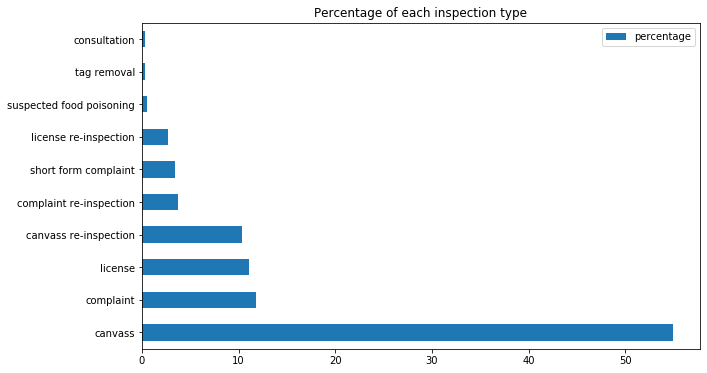

In [13]:
inspection_type_percent.iloc[:10].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of each inspection type')

**Observation**
1. We can obserse that we have 54 different inspection types, but only the top 7 inspection types have percentage more than 1% and constitue the 98% of the total inspection results.
2. We select the top 7 inspection types and analysis them.

In [14]:
selected_inspection_type = inspection_type_percent.where(inspection_type_percent['percentage'] >= 1).dropna().index.tolist()
print("Our selected inspection type is \n", selected_inspection_type)

Our selected inspection type is 
 ['canvass', 'complaint', 'license', 'canvass re-inspection', 'complaint re-inspection', 'short form complaint', 'license re-inspection']


In [15]:
def get_stats_info(valid_type, original_table, type_):
    """get the statistic results of different inspection/facility types in terms of different violations
    Args:
        valid_type: inspection/facility types that we selected
        original_table : the table contains all the inspection/facility types
        type_: the field on which we want to do the statistics (inspection/facility type)
    Returns:
        stats: Number of occurrences of each violation number for different inspection/facility types
        stats_percentage: percentage of each violation number for different inspection/facility types
        stats_percentage_sorted: dataframe with each row being the sorted percentage and violations number  
    """
    # select rows with inspection/facilty type in the valid_type
    valid_table = original_table[original_table[type_].isin(valid_type)]
    
    # count the number of occurrances of each violation number for different inspection/facility types
    stats = valid_table.groupby(type_)['Violations Number']\
                       .apply(lambda x: x.value_counts())\
                       .unstack()\
                       .fillna(0.0)
    # sort the row according to the valid_type sequence
    stats =stats.loc[valid_type, :]
    
    # add a row to record the sum of occurrences of different types for each violation
    stats.loc['total'] = stats.sum(axis=0)
    
    # sort the column according to the violations number(this step make the table much more readable)
    sorted_name = sorted(stats.columns.astype(int))
    stats= stats.reindex([str(i) for i in sorted_name], axis=1)
    
    # get the percentage of each violation number for different types(facility/inspection)
    stats_percentage = stats.apply(lambda x: round((x/x.sum())*100, 3), axis=1)
    # get the sorted version
    column = stats_percentage.columns.values
    y = [list(zip(stats_percentage.loc[y], column)) for y in valid_type]
    [x.sort(reverse=True) for x in y]
    stats_percentage_sorted = pd.DataFrame(y, index=valid_type)
    
    return stats[:-1], stats_percentage[:-1], stats_percentage_sorted

In [16]:
# get statistic result for valid facilty before changing food rules
stats_inspection_old, stats_percentage_inspection_old, stats_percentage_sorted_inspection_old\
    = get_stats_info(selected_inspection_type, chicago_before, 'Inspection Type')

# get statistic result for valid facilty after changing food rules
stats_inspection_new, stats_percentage_inspection_new, stats_percentage_sorted_inspection_new\
    = get_stats_info(selected_inspection_type, chicago_after, 'Inspection Type')

In [17]:
stats_inspection_old.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,70
Inspection Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
canvass,324.0,3037.0,5879.0,282.0,8.0,1088.0,79.0,1558.0,556.0,328.0,1403.0,1543.0,213.0,44.0,1.0,2989.0,86.0,8403.0,2020.0,24.0,5408.0,664.0,2.0,1419.0,86.0,839.0,223.0,878.0,4049.0,10178.0,6277.0,30315.0,37892.0,41180.0,35492.0,13970.0,3119.0,29553.0,417.0,8414.0,18082.0,4087.0,5170.0,231.0,4546.0,255.0
complaint,213.0,1059.0,2314.0,161.0,6.0,566.0,27.0,512.0,220.0,128.0,525.0,627.0,164.0,16.0,1.0,962.0,28.0,3147.0,779.0,12.0,1487.0,199.0,2.0,454.0,48.0,213.0,37.0,287.0,1285.0,2418.0,1429.0,7383.0,9285.0,10399.0,8607.0,3473.0,732.0,6619.0,108.0,2042.0,4476.0,1102.0,1318.0,54.0,990.0,111.0
license,52.0,1643.0,220.0,16.0,0.0,25.0,19.0,373.0,607.0,239.0,1306.0,608.0,27.0,1.0,0.0,756.0,2.0,3269.0,1050.0,51.0,889.0,223.0,1.0,931.0,17.0,209.0,97.0,10.0,74.0,689.0,428.0,5301.0,4073.0,5921.0,6767.0,2722.0,1661.0,6783.0,17.0,1867.0,3779.0,159.0,218.0,25.0,225.0,128.0


In [18]:
stats_percentage_inspection_old.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,70
Inspection Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
canvass,0.111,1.038,2.009,0.096,0.003,0.372,0.027,0.532,0.190,0.112,0.479,0.527,0.073,0.015,0.000,1.021,0.029,2.872,0.690,0.008,1.848,0.227,0.001,0.485,0.029,0.287,0.076,0.300,1.384,3.478,2.145,10.360,12.950,14.073,12.129,4.774,1.066,10.100,0.143,2.875,6.180,1.397,1.767,0.079,1.554,0.087
complaint,0.280,1.393,3.044,0.212,0.008,0.744,0.036,0.673,0.289,0.168,0.691,0.825,0.216,0.021,0.001,1.265,0.037,4.139,1.025,0.016,1.956,0.262,0.003,0.597,0.063,0.280,0.049,0.378,1.690,3.181,1.880,9.711,12.213,13.678,11.321,4.568,0.963,8.706,0.142,2.686,5.888,1.450,1.734,0.071,1.302,0.146
license,0.097,3.072,0.411,0.030,0.000,0.047,0.036,0.697,1.135,0.447,2.442,1.137,0.050,0.002,0.000,1.414,0.004,6.113,1.963,0.095,1.662,0.417,0.002,1.741,0.032,0.391,0.181,0.019,0.138,1.288,0.800,9.912,7.616,11.072,12.654,5.090,3.106,12.684,0.032,3.491,7.066,0.297,0.408,0.047,0.421,0.239


In [19]:
stats_percentage_sorted_inspection_old.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
canvass,"(14.073, 34)","(12.95, 33)","(12.129, 35)","(10.36, 32)","(10.1, 38)","(6.18, 41)","(4.774, 36)","(3.478, 30)","(2.875, 40)","(2.872, 18)","(2.145, 31)","(2.009, 3)","(1.848, 21)","(1.767, 43)","(1.554, 45)","(1.397, 42)","(1.384, 29)","(1.066, 37)","(1.038, 2)","(1.021, 16)","(0.69, 19)","(0.532, 8)","(0.527, 12)","(0.485, 24)","(0.479, 11)","(0.372, 6)","(0.3, 28)","(0.287, 26)","(0.227, 22)","(0.19, 9)","(0.143, 39)","(0.112, 10)","(0.111, 1)","(0.096, 4)","(0.087, 70)","(0.079, 44)","(0.076, 27)","(0.073, 13)","(0.029, 25)","(0.029, 17)","(0.027, 7)","(0.015, 14)","(0.008, 20)","(0.003, 5)","(0.001, 23)","(0.0, 15)"
complaint,"(13.678, 34)","(12.213, 33)","(11.321, 35)","(9.711, 32)","(8.706, 38)","(5.888, 41)","(4.568, 36)","(4.139, 18)","(3.181, 30)","(3.044, 3)","(2.686, 40)","(1.956, 21)","(1.88, 31)","(1.734, 43)","(1.69, 29)","(1.45, 42)","(1.393, 2)","(1.302, 45)","(1.265, 16)","(1.025, 19)","(0.963, 37)","(0.825, 12)","(0.744, 6)","(0.691, 11)","(0.673, 8)","(0.597, 24)","(0.378, 28)","(0.289, 9)","(0.28, 26)","(0.28, 1)","(0.262, 22)","(0.216, 13)","(0.212, 4)","(0.168, 10)","(0.146, 70)","(0.142, 39)","(0.071, 44)","(0.063, 25)","(0.049, 27)","(0.037, 17)","(0.036, 7)","(0.021, 14)","(0.016, 20)","(0.008, 5)","(0.003, 23)","(0.001, 15)"
license,"(12.684, 38)","(12.654, 35)","(11.072, 34)","(9.912, 32)","(7.616, 33)","(7.066, 41)","(6.113, 18)","(5.09, 36)","(3.491, 40)","(3.106, 37)","(3.072, 2)","(2.442, 11)","(1.963, 19)","(1.741, 24)","(1.662, 21)","(1.414, 16)","(1.288, 30)","(1.137, 12)","(1.135, 9)","(0.8, 31)","(0.697, 8)","(0.447, 10)","(0.421, 45)","(0.417, 22)","(0.411, 3)","(0.408, 43)","(0.391, 26)","(0.297, 42)","(0.239, 70)","(0.181, 27)","(0.138, 29)","(0.097, 1)","(0.095, 20)","(0.05, 13)","(0.047, 6)","(0.047, 44)","(0.036, 7)","(0.032, 39)","(0.032, 25)","(0.03, 4)","(0.019, 28)","(0.004, 17)","(0.002, 23)","(0.002, 14)","(0.0, 5)","(0.0, 15)"


**We calculate the correlation between different inspection types (use the percentage of each violation number)**

In [56]:
# concatenate the data before and after the change of inspection rules.
# we have 46 inspection rules(1-45 and 70) before change and 63 inspection rule(1-63) after change. After concatenate we have 109 columns.
stats_facility_concat = pd.concat([stats_inspection_old, stats_inspection_new], axis=1)
stats_facility_concat = stats_facility_concat.fillna(0.0)
stats_facility_concat = stats_facility_concat.apply(lambda x: round((x/x.sum())*100, 2), axis=1)
stats_facility_concat

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,70,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
Inspection Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
canvass,0.09,0.86,1.67,0.08,0.00,0.31,0.02,0.44,0.16,0.09,0.40,0.44,0.06,0.01,0.0,0.85,0.02,2.38,0.57,0.01,1.53,0.19,0.0,0.40,0.02,0.24,0.06,0.25,1.15,2.89,1.78,8.60,10.75,11.68,10.07,3.96,0.88,8.38,0.12,2.39,5.13,1.16,1.47,0.07,1.29,0.07,0.10,0.23,1.53,0.0,1.62,0.01,0.0,0.04,0.04,0.84,0.01,0.00,0.01,0.02,0.02,0.22,0.0,0.0,0.00,0.01,0.05,0.23,0.75,0.00,0.50,0.0,0.0,0.01,0.04,0.0,0.00,0.02,0.12,0.0,0.02,0.38,0.53,0.47,0.26,0.15,0.27,0.0,0.11,0.16,0.07,0.01,1.07,0.24,0.74,0.03,0.87,0.05,0.30,0.13,2.37,0.72,0.45,1.00,0.00,0.12,0.04,0.01,0.00
complaint,0.23,1.15,2.52,0.18,0.01,0.62,0.03,0.56,0.24,0.14,0.57,0.68,0.18,0.02,0.0,1.05,0.03,3.42,0.85,0.01,1.62,0.22,0.0,0.49,0.05,0.23,0.04,0.31,1.40,2.63,1.55,8.03,10.09,11.31,9.36,3.78,0.80,7.20,0.12,2.22,4.87,1.20,1.43,0.06,1.08,0.12,0.12,0.26,1.30,0.0,1.36,0.03,0.0,0.05,0.05,0.89,0.01,0.00,0.02,0.03,0.04,0.31,0.0,0.0,0.00,0.01,0.08,0.35,0.56,0.01,0.37,0.0,0.0,0.02,0.05,0.0,0.00,0.03,0.17,0.0,0.03,0.41,0.48,0.71,0.25,0.19,0.32,0.0,0.12,0.15,0.08,0.02,1.06,0.27,0.93,0.05,0.73,0.07,0.27,0.15,2.54,0.76,0.45,0.88,0.00,0.23,0.07,0.01,0.00
license,0.08,2.50,0.33,0.02,0.00,0.04,0.03,0.57,0.92,0.36,1.99,0.93,0.04,0.00,0.0,1.15,0.00,4.98,1.60,0.08,1.35,0.34,0.0,1.42,0.03,0.32,0.15,0.02,0.11,1.05,0.65,8.07,6.20,9.01,10.30,4.14,2.53,10.33,0.03,2.84,5.75,0.24,0.33,0.04,0.34,0.19,0.07,0.19,2.18,0.0,2.38,0.00,0.0,0.00,0.00,0.99,0.01,0.00,0.00,0.00,0.01,0.15,0.0,0.0,0.00,0.00,0.03,0.06,0.16,0.00,0.27,0.0,0.0,0.01,0.01,0.0,0.01,0.01,0.27,0.0,0.00,0.51,0.23,0.86,0.48,0.03,0.07,0.0,0.04,0.08,0.03,0.00,0.80,0.63,0.45,0.14,1.15,0.10,0.54,0.26,2.68,0.82,0.77,1.03,0.00,0.01,0.00,0.02,0.00
canvass re-inspection,0.02,0.12,0.12,0.01,0.00,0.02,0.01,0.06,0.12,0.08,0.15,0.05,0.18,1.83,0.0,0.25,0.00,1.03,0.24,0.01,0.98,0.04,0.0,0.22,0.01,0.13,0.02,0.21,0.60,2.56,1.40,10.04,9.13,11.16,11.50,4.58,0.92,9.11,0.09,1.93,5.46,0.78,1.27,0.09,2.02,0.04,0.05,0.19,1.81,0.0,2.00,0.01,0.0,0.01,0.00,0.82,0.00,0.00,0.00,0.02,0.00,0.15,0.0,0.0,0.00,0.00,0.00,0.01,0.99,0.00,0.73,0.0,0.0,0.00,0.05,0.0,0.00,0.02,0.04,0.0,0.01,0.41,0.75,0.54,0.36,0.13,0.31,0.0,0.08,0.19,0.10,0.02,1.52,0.22,1.08,0.02,1.26,0.04,0.44,0.08,3.29,1.04,0.83,1.36,0.33,0.07,0.03,0.00,0.01
complaint re-inspection,0.04,0.31,0.16,0.04,0.00,0.04,0.02,0.08,0.15,0.16,0.18,0.09,0.42,2.02,0.0,0.25,0.01,1.41,0.32,0.02,1.26,0.04,0.0,0.25,0.02,0.06,0.00,0.21,0.65,2.62,1.46,9.03,10.08,11.94,11.22,4.26,0.88,8.17,0.11,2.04,5.56,0.86,1.38,0.06,1.55,0.06,0.07,0.24,1.78,0.0,2.04,0.00,0.0,0.00,0.00,0.68,0.00,0.00,0.01,0.02,0.01,0.15,0.0,0.0,0.00,0.00,0.01,0.02,0.65,0.00,0.51,0.0,0.0,0.00,0.04,0.0,0.00,0.02,0.06,0.0,0.00,0.40,0.62,0.66,0.30,0.16,0.37,0.0,0.11,0.20,0.09,0.04,1.44,0.18,1.28,0.03,0.95,0.05,0.37,0.13,3.38,0.84,0.73,1.15,0.48,0.16,0.05,0.00,0.01
short form complaint,0.16,0.56,1.41,0.03,0.00,0.50,0.02,0.13,0.17,0.11,0.36,0.41,0.07,0.00,0.0,0.58,0.03,2.88,0.38,0.02,2.59,0.02,0.0,0.18,0.03,0.22,0.05,0.32,0.53,2.61,1.73,9.49,11.74,14.40,11.64,4.70,1.10,8.64,0.09,2.56,6.05,1.64,1.43,0.09,0.84,0.10,0.07,0.22,0.83,0.0,0.89,0.00,0.0,0.02,0.02,0.42,0.00,0.01,0.01,0.00,0.04,0.10,0.0,0.0,0.00,0.01,0.00,0.10,0.26,0.00,0.23,0.0,0.0,0.01,0.01,0.0,0.00,0.01,0.03,0.0,0.01,0.13,0.23,0.54,0.10,0.13,0.17,0.0,0.06,0.05,0.04,0.01,0.54,0.07,0.51,0.01,0.43,0.02,0.15,0.05,1.48,0.44,0.26,0.62,0.01,0.09,0.02,0.00,0.00
license re-inspection,0.07,1.56,0.08,0.04,0.00,0.02,0.01,0.43,0.69,0.31,0.83,0.28,0.12,0.46,0.0,0.60,0.00,2.60,0.54,0.03,0.90,0.10,0.0,0.95,0.00,0.12,0.05,0.03,0.13,0.90,0.54,8.91,5.89,9.18,11.41,4.05,1.83,12.36,0.02,1.96,6.66,0.18,0.25,0.01,0.53,0.11,

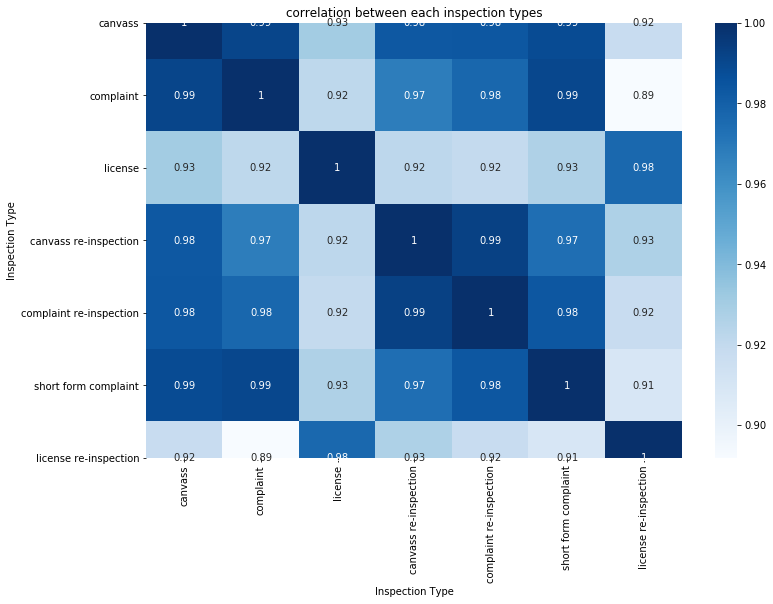

In [57]:
# plot the correlation between each inspection types
plt.figure(figsize=(12,8))
corr = stats_inspection_concat.transpose().corr()
sns.heatmap(corr,annot=True,cmap=plt.cm.Blues)
plt.title("correlation between each inspection types")
plt.show()

## Observation
1. We can observe the correlation between `license` and `license re-inspection` is 0.98, while the correlation between `license` and other inspection type is around 0.92, a liitle bit smaller than 0.98.
2. We can also observe the correlation between `license re-inspection` and `license` is 0.98, while the correlation between `license re-inspection` and other inspection type is around 0.92, a liitle bit smaller than 0.98.
3. The correlation between [`canvass`, `canvass re-inspection`, `complaint`, `short form complaint`, `complaint re-inspection`] is around 0.98.
4. We can roughly say that [`license`, `license re-inspection`] is a class, and [`canvass`, `canvass re-inspection`, `complaint`, `short form complaint`, `complaint re-inspection`] is another class. We use K-means to verify them

In [22]:
def K_mean_func(data, max_k):
    SSE = []
    X = []
    for i in range(n):
        kms = KMeans(n_clusters = i + 1)
        predicted_labels = kms.fit_predict(data)
        print("K(number of clusters):", i + 1)
        SSE.append(kms.inertia_)
        X.append(i + 1)
        for j in range(i + 1):
            print()
            print("class", j + 1, ":", np.where(predicted_labels == j))
        print()
    plt.xlabel('K')
    plt.ylabel('SSE(measures the quality of K-means)')
    plt.plot(X,SSE,'o-')
    plt.show()

K(number of clusters): 1

class 1 : (array([0, 1, 2, 3, 4, 5, 6], dtype=int64),)

K(number of clusters): 2

class 1 : (array([0, 1, 3, 4, 5], dtype=int64),)

class 2 : (array([2, 6], dtype=int64),)

K(number of clusters): 3

class 1 : (array([0, 1, 5], dtype=int64),)

class 2 : (array([2, 6], dtype=int64),)

class 3 : (array([3, 4], dtype=int64),)

K(number of clusters): 4

class 1 : (array([2], dtype=int64),)

class 2 : (array([0, 1, 5], dtype=int64),)

class 3 : (array([3, 4], dtype=int64),)

class 4 : (array([6], dtype=int64),)

K(number of clusters): 5

class 1 : (array([3, 4], dtype=int64),)

class 2 : (array([6], dtype=int64),)

class 3 : (array([2], dtype=int64),)

class 4 : (array([0, 1], dtype=int64),)

class 5 : (array([5], dtype=int64),)



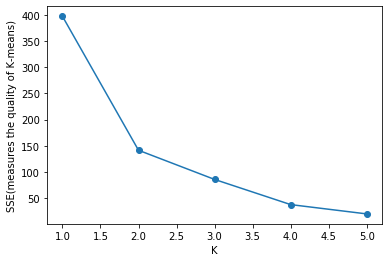

In [58]:
K_mean_func(stats_inspection_concat.values, 5)


We can see that clustering works well when K = 2. The clustering results are the same as our previous guess. [2, 6] is a class "license", and [0, 1, 3, 4, 5] is another class "other".
We can see that the difference between canvass and complaint is not obvious, and whether re-inspection does not have much influence.

In [114]:
def plot_scatter(data, x_index, y_index, x_label, y_label, text_size, add_line):
    x_data = data.iloc[x_index, :]
    x_data= x_data.apply(lambda x: x.sum(),axis = 0)
    sum_x_data = np.sum(x_data)
    x_data = x_data/sum_x_data
    
    y_data = data.iloc[y_index, :]
    y_data= y_data.apply(lambda x: x.sum(),axis = 0)
    sum_y_data = np.sum(y_data)
    y_data = y_data/sum_y_data
    
    text = x_data._stat_axis.values.tolist()
    
    plt.scatter(x_data, y_data)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    for i in range(len(x_data)):
        if(x_data[i] >= text_size[0]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
        elif(y_data[i] >= text_size[1]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
        elif(x_data[i] - y_data[i] >= text_size[5]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
        elif(y_data[i] - x_data[i] >= text_size[6]):
            plt.annotate(text[i], xy = (x_data[i], y_data[i]), xytext = (x_data[i] - text_size[2], y_data[i] - text_size[3]))
    if(add_line == True):
        plt.plot([0, text_size[4]],[0, text_size[4]])
    plt.show()

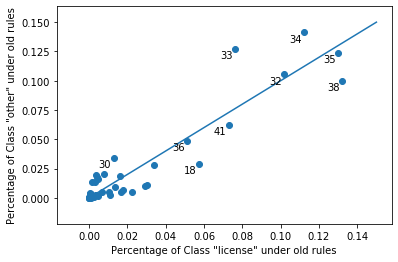

In [115]:
x_index = [2, 6]
y_index = [0, 1, 3, 4, 5]
x_label = 'Percentage of Class "license" under old rules'
y_label = 'Percentage of Class "other" under old rules'
text_size = [0.05, 0.05, 0.008, 0.008, 0.15, 0.02, 0.02]
add_line = True
plot_scatter(stats_inspection_old, x_index, y_index, x_label, y_label, text_size, add_line)

We can see that the inspection for the license: 18, 38 is relatively more, 33, 34 is relatively less. Check the previous information:
18  no evidence of rodent or insect outer openings protected/rodent proofed, a written log shall be maintained available to the inspectors
38  ventilation: rooms and equipment vented as required: plumbing: installed and maintained
33  food and non-food contact equipment utensils clean, free of abrasive detergents
34  floors: constructed per code, cleaned, good repair, coving installed, dust-less cleaning methods used

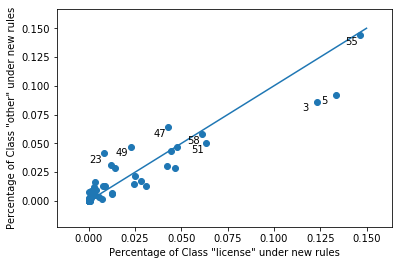

In [116]:
x_index = [2, 6]
y_index = [0, 1, 3, 4, 5]
x_label = 'Percentage of Class "license" under new rules'
y_label = 'Percentage of Class "other" under new rules'
text_size = [0.05, 0.05, 0.008, 0.008, 0.15, 0.02, 0.02]
add_line = True
plot_scatter(stats_inspection_new, x_index, y_index, x_label, y_label, text_size, add_line)

We can see that the inspection for the license: 3, 5 is relatively more, 23, 47, 49 is relatively less. Check the previous information:
3 management, food employee and conditional employee; knowledge, responsibilities and reporting
5 procedures for responding to vomiting and diarrheal events
23 proper date marking and disposition
47 food & non-food contact surfaces cleanable, properly designed, constructed & used
49 non-food/food contact surfaces clean

Based on the above, we can think of the inspection for the receive license: equipment, personnel, prevention work problems are more common, and cleaning problems are less common. This is also in line with common sense.

## 2.3 Facility type

Plot the percentage of the different facility types and select the facility types that makes up the most of the inspections to do further analysis. For each facility type, find the violations that occurs very often and analysis the reasons. Whether there are some similarities and differences between these facility types in terms of the violations that easily violated.

The column *'Facility Type'* contains different facility types. Before we start, we want to show the percentage of different facility types.

In [26]:
facility_type_percent = pd.DataFrame({'count': chicago_all['Facility Type'].value_counts(), \
                                      'percentage':(chicago_all['Facility Type'].value_counts()/chicago_all['Facility Type'].count())*100})
facility_type_percent['cumulative percentage'] = facility_type_percent['percentage'].cumsum()
print('The total number of facility types is %d' % facility_type_percent.shape[0])
facility_type_percent.head(3)

The total number of facility types is 383


,count,percentage,cumulative percentage
restaurant,98631,68.717081,68.717081
grocery store,18019,12.553995,81.271075
school,10636,7.410194,88.681270


**Plot the percentage of facility type**

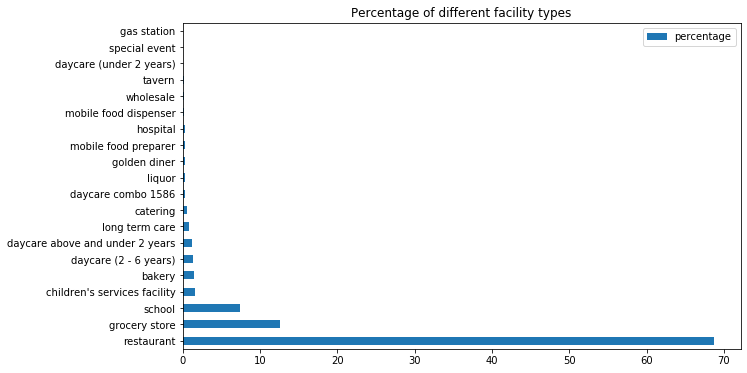

In [27]:
facility_type_percent.iloc[:20].plot(y='percentage', kind='barh', \
                                       figsize=(10, 6), title='Percentage of different facility types')

**Observation**
1. We can obserse that we have 383 different facility types, but only the top 20 facility types have number of inspection more than 100 and constitue the 98% of the total inspection results.
2. We select the top 20 facility types and analysis them.

In [28]:
selected_facility_type = facility_type_percent.where(facility_type_percent['count'] >= 100).dropna().index.tolist()
print("Our selected facility types are: \n", selected_facility_type)

Our selected facility types are: 
 ['restaurant', 'grocery store', 'school', "children's services facility", 'bakery', 'daycare (2 - 6 years)', 'daycare above and under 2 years', 'long term care', 'catering', 'daycare combo 1586', 'liquor', 'golden diner', 'mobile food preparer', 'hospital', 'mobile food dispenser', 'wholesale', 'tavern', 'daycare (under 2 years)', 'special event', 'gas station']


In [29]:
# get statistic result for valid facilty before the change of food rules
stats_facility_old, stats_percentage_facility_old, stats_percentage_sorted_facility_old\
    = get_stats_info(selected_facility_type, chicago_before, 'Facility Type')

# get statistic result for valid facilty after the change of food rules
stats_facility_new, stats_percentage_facility_new, stats_percentage_sorted_facility_new\
    = get_stats_info(selected_facility_type, chicago_after, 'Facility Type')

In [30]:
stats_percentage_sorted_facility_old.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
restaurant,"(13.386, 34)","(12.632, 33)","(11.72, 35)","(10.929, 32)","(9.809, 38)","(5.534, 41)","(4.69, 36)","(3.71, 30)","(2.9, 40)","(2.87, 18)","(2.279, 31)","(1.978, 3)","(1.961, 43)","(1.847, 21)","(1.789, 45)","(1.472, 42)","(1.283, 29)","(1.238, 2)","(1.145, 37)","(1.13, 16)","(0.743, 19)","(0.643, 11)","(0.59, 8)","(0.57, 24)","(0.568, 12)","(0.431, 6)","(0.319, 28)","(0.271, 14)","(0.253, 9)","(0.215, 22)","(0.16, 10)","(0.152, 26)","(0.15, 39)","(0.116, 4)","(0.111, 1)","(0.095, 13)","(0.088, 70)","(0.075, 44)","(0.04, 27)","(0.031, 25)","(0.03, 17)","(0.028, 7)","(0.014, 20)","(0.004, 5)","(0.001, 23)","(0.001, 15)"
grocery store,"(14.715, 34)","(12.567, 35)","(11.196, 33)","(9.835, 32)","(9.829, 38)","(8.781, 41)","(5.445, 36)","(4.297, 18)","(3.491, 40)","(2.083, 37)","(1.861, 21)","(1.81, 30)","(1.45, 3)","(1.33, 2)","(1.08, 19)","(0.913, 31)","(0.878, 29)","(0.855, 11)","(0.833, 24)","(0.77, 16)","(0.748, 43)","(0.705, 42)","(0.692, 12)","(0.594, 45)","(0.484, 9)","(0.327, 14)","(0.324, 26)","(0.269, 1)","(0.247, 22)","(0.222, 28)","(0.213, 70)","(0.193, 13)","(0.188, 8)","(0.185, 6)","(0.172, 10)","(0.084, 39)","(0.078, 27)","(0.066, 4)","(0.052, 44)","(0.048, 20)","(0.045, 25)","(0.034, 7)","(0.011, 17)","(0.0, 5)","(0.0, 23)","(0.0, 15)"
school,"(17.47, 35)","(16.466, 38)","(15.054, 34)","(9.547, 33)","(9.273, 32)","(8.5, 41)","(6.04, 36)","(3.538, 18)","(1.562, 40)","(1.459, 26)","(1.141, 29)","(1.016, 19)","(0.944, 37)","(0.851, 21)","(0.767, 31)","(0.748, 30)","(0.708, 14)","(0.686, 3)","(0.499, 2)","(0.48, 27)","(0.377, 11)","(0.333, 24)","(0.327, 42)","(0.309, 43)","(0.296, 12)","(0.234, 9)","(0.231, 16)","(0.196, 8)","(0.193, 45)","(0.171, 13)","(0.156, 44)","(0.084, 6)","(0.072, 10)","(0.059, 28)","(0.047, 22)","(0.041, 39)","(0.031, 4)","(0.025, 25)","(0.022, 7)","(0.019, 70)","(0.019, 17)","(0.006, 1)","(0.003, 5)","(0.003, 20)","(0.0, 23)","(0.0, 15)"


In [31]:
stats_percentage_sorted_facility_new.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
restaurant,"(13.214, 55)","(9.104, 5)","(8.934, 3)","(7.362, 58)","(6.194, 47)","(4.772, 51)","(4.407, 49)","(4.35, 10)","(4.277, 23)","(4.132, 56)","(3.375, 25)","(3.331, 57)","(3.142, 37)","(2.681, 38)","(2.077, 36)","(1.746, 53)","(1.63, 39)","(1.621, 41)","(1.346, 48)","(1.319, 16)","(1.236, 2)","(1.197, 22)","(0.979, 44)","(0.869, 40)","(0.813, 60)","(0.751, 33)","(0.716, 54)","(0.638, 43)","(0.505, 1)","(0.425, 45)","(0.312, 52)","(0.245, 59)","(0.242, 61)","(0.232, 21)","(0.217, 29)","(0.216, 9)","(0.214, 8)","(0.195, 50)","(0.162, 15)","(0.12, 32)","(0.116, 35)","(0.115, 14)","(0.092, 6)","(0.079, 46)","(0.068, 28)","(0.039, 11)","(0.035, 20)","(0.031, 13)","(0.028, 62)","(0.016, 24)","(0.014, 30)","(0.013, 63)","(0.012, 19)","(0.011, 17)","(0.008, 4)","(0.008, 31)","(0.005, 42)","(0.005, 12)","(0.002, 7)","(0.002, 27)","(0.002, 18)","(0.001, 26)","(0.0, 34)"
grocery store,"(17.164, 55)","(11.21, 5)","(8.753, 3)","(7.443, 47)","(5.408, 51)","(5.246, 49)","(4.753, 10)","(4.699, 56)","(4.161, 38)","(3.444, 36)","(3.103, 57)","(2.52, 48)","(2.278, 23)","(2.26, 37)","(2.134, 53)","(1.686, 39)","(1.381, 41)","(1.067, 58)","(1.058, 2)","(0.96, 22)","(0.933, 54)","(0.843, 33)","(0.807, 16)","(0.682, 25)","(0.583, 40)","(0.502, 1)","(0.43, 21)","(0.421, 44)","(0.413, 43)","(0.395, 52)","(0.395, 50)","(0.359, 29)","(0.35, 59)","(0.332, 60)","(0.314, 45)","(0.206, 61)","(0.197, 14)","(0.161, 35)","(0.143, 32)","(0.135, 13)","(0.117, 15)","(0.108, 8)","(0.081, 28)","(0.072, 46)","(0.054, 9)","(0.054, 62)","(0.036, 11)","(0.027, 20)","(0.027, 19)","(0.027, 17)","(0.018, 6)","(0.018, 4)","(0.009, 34)","(0.009, 31)","(0.009, 24)","(0.009, 18)","(0.0, 7)","(0.0, 63)","(0.0, 42)","(0.0, 30)","(0.0, 27)","(0.0, 26)","(0.0, 12)"
school,"(22.821, 55)","(12.85, 10)","(10.637, 51)","(9.411, 5)","(6.185, 38)","(5.998, 56)","(5.279, 3)","(4.612, 47)","(3.386, 49)","(2.426, 53)","(1.653, 39)","(1.626, 48)","(1.573, 54)","(1.2, 2)","(1.12, 36)","(1.12, 23)","(0.96, 57)","(0.906, 37)","(0.773, 50)","(0.72, 59)","(0.613, 1)","(0.587, 52)","(0.453, 16)","(0.373, 41)","(0.32, 22)","(0.293, 40)","(0.267, 58)","(0.24, 60)","(0.24, 33)","(0.187, 45)","(0.187, 44)","(0.16, 21)","(0.133, 61)","(0.133, 43)","(0.107, 6)","(0.107, 28)","(0.053, 9)","(0.053, 19)","(0.053, 17)","(0.027, 8)","(0.027, 62)","(0.027, 46)","(0.027, 35)","(0.027, 25)","(0.027, 15)","(0.027, 12)","(0.0, 7)","(0.0, 63)","(0.0, 42)","(0.0, 4)","(0.0, 34)","(0.0, 32)","(0.0, 31)","(0.0, 30)","(0.0, 29)","(0.0, 27)","(0.0, 26)","(0.0, 24)","(0.0, 20)","(0.0, 18)","(0.0, 14)","(0.0, 13)","(0.0, 11)"


**Due to the large amount of data, we use K-means for clustering directly**

Concat the number of different "Violations Number" occurrences before and after revision the rule. We can get 109 different Violations. Calculate the percentage of each Violations for Facility Type and Inspection Type.

Due to the large amount of data, we use K-means for clustering directly.

In [46]:
# concatenate the data before and after the change of inspection rules.
# we have 46 inspection rules(1-45 and 70) before change and 63 inspection rule(1-63) after change. After concatenate we have 109 columns.
stats_facility_concat = pd.concat([stats_facility_old, stats_facility_new], axis=1)
stats_facility_concat = stats_facility_concat.fillna(0.0)
stats_facility_concat = stats_facility_concat.apply(lambda x: round((x/x.sum())*100, 2), axis=1)

K(number of clusters): 1

class 1 : (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64),)

K(number of clusters): 2

class 1 : (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18,
       19], dtype=int64),)

class 2 : (array([12, 14], dtype=int64),)

K(number of clusters): 3

class 1 : (array([12, 14], dtype=int64),)

class 2 : (array([ 0,  3,  4,  7,  8, 11, 13, 18], dtype=int64),)

class 3 : (array([ 1,  2,  5,  6,  9, 10, 15, 16, 17, 19], dtype=int64),)

K(number of clusters): 4

class 1 : (array([ 0,  1,  3,  4,  7,  8, 11, 13, 18], dtype=int64),)

class 2 : (array([12, 14], dtype=int64),)

class 3 : (array([ 2,  5,  6,  9, 15, 17, 19], dtype=int64),)

class 4 : (array([10, 16], dtype=int64),)

K(number of clusters): 5

class 1 : (array([10, 16], dtype=int64),)

class 2 : (array([ 0,  1,  3,  4,  7,  8, 11, 13, 18], dtype=int64),)

class 3 : (array([12], dtype=int64),)

class 4 : (array([ 2,  5,  6,  9,

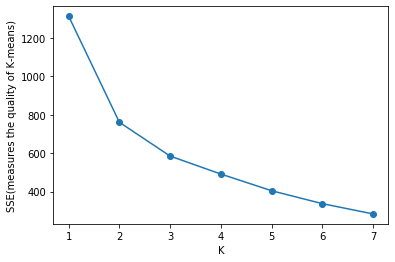

In [48]:
K_mean_func(stats_facility_concat.values, 7)

We can see that clustering works well when K = 4. The four categories are:[12, 14], [10, 16], [ 2,  5,  6,  9, 15, 17, 19], [ 0,  1,  3,  4,  7,  8, 11, 13, 18]

We can see that there are obvious differences between the four categories. 
The first category is mobile. 
The second category is related to wine. 
The third category is daycare, school, wholesale, gas station. 
The fourth category is normal restaurants and hospitals. 
The difference between the third category and the fourth category is mainly that the third category is relatively poorly clean, while the fourth category is better.

In [49]:
valid_facility = pd.Series(selected_facility_type)
mobile = valid_facility.iloc[[12, 14]]
liquor_tavern = valid_facility.iloc[[10, 16]]
daycare = valid_facility.iloc[[ 2, 5, 6, 9, 15, 17, 19]]
restaurant = valid_facility.iloc[[ 0, 1, 3, 4, 7, 8, 11, 13, 18]]
print(mobile.values,'\n=======================')
print(liquor_tavern.values,'\n=======================')
print(daycare.values,'\n=======================')
print(restaurant.values)

['mobile food preparer' 'mobile food dispenser'] 
['liquor' 'tavern'] 
['school' 'daycare (2 - 6 years)' 'daycare above and under 2 years'
 'daycare combo 1586' 'wholesale' 'daycare (under 2 years)' 'gas station'] 
['restaurant' 'grocery store' "children's services facility" 'bakery'
 'long term care' 'catering' 'golden diner' 'hospital' 'special event']


We can see that there are obvious differences between the four categories. The first category is mobile. The second category is related to wine. The third category is daycare, school, wholesale. The fourth category is normal restaurants and hospitals. The difference between the third category and the fourth category is mainly that the third category is relatively poorly clean, while the fourth category is better.

**We divide the data according to these four categories and continue to analyze**

In [50]:
class_list = ["mobile", "liquor_tavern", "daycare", "border_restaurant"]

In [51]:
def decide_cluster_type(x):
    if(x in mobile.values):
        return "mobile"
    elif(x in liquor_tavern.values):
        return "liquor_tavern"
    elif(x in daycare.values):
        return "daycare"
    elif(x in restaurant.values):
        return "border_restaurant"
    else:
        return "unknown"

In [52]:
chicago_before['Cluster Type'] = chicago_before.apply(lambda x: decide_cluster_type(x['Facility Type']), axis=1)
chicago_after['Cluster Type'] = chicago_after.apply(lambda x: decide_cluster_type(x['Facility Type']), axis=1)

In [84]:
# get statistic result for valid facilty before change food rules
stats_cluster_old, stats_percentage_cluster_old, stats_percentage_sorted_cluster_old\
    = get_stats_info(["mobile", "liquor_tavern", "daycare", "border_restaurant"], chicago_before, 'Cluster Type')

# get statistic result for valid facilty after change food rules
stats_cluster_new, stats_percentage_cluster_new, stats_percentage_sorted_cluster_new\
    = get_stats_info(["mobile", "liquor_tavern", "daycare", "border_restaurant"], chicago_after, 'Cluster Type')

In [54]:
stats_percentage_sorted_cluster_old

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
mobile,"(10.957, 32)","(9.901, 38)","(8.911, 18)","(8.647, 30)","(7.393, 2)","(6.865, 9)","(6.667, 35)","(5.809, 34)","(5.149, 33)","(3.696, 40)","(3.036, 10)","(2.574, 11)","(2.376, 21)","(2.244, 24)","(2.244, 16)","(1.782, 36)","(1.584, 12)","(1.386, 45)","(1.386, 3)","(1.32, 1)","(0.99, 41)","(0.858, 31)","(0.726, 29)","(0.66, 42)","(0.66, 20)","(0.594, 22)","(0.396, 6)","(0.33, 19)","(0.198, 43)","(0.198, 28)","(0.132, 8)","(0.066, 7)","(0.066, 39)","(0.066, 37)","(0.066, 26)","(0.066, 14)","(0.0, 70)","(0.0, 5)","(0.0, 44)","(0.0, 4)","(0.0, 27)","(0.0, 25)","(0.0, 23)","(0.0, 17)","(0.0, 15)","(0.0, 13)"
liquor_tavern,"(13.794, 34)","(13.315, 38)","(11.435, 35)","(9.556, 18)","(9.356, 33)","(8.956, 32)","(8.517, 41)","(3.239, 37)","(2.759, 11)","(2.479, 36)","(2.239, 16)","(1.719, 43)","(1.599, 24)","(1.599, 19)","(1.279, 12)","(0.88, 40)","(0.8, 8)","(0.8, 26)","(0.76, 2)","(0.64, 70)","(0.44, 9)","(0.44, 4)","(0.36, 42)","(0.32, 22)","(0.32, 13)","(0.32, 10)","(0.28, 31)","(0.28, 29)","(0.28, 27)","(0.28, 14)","(0.24, 30)","(0.12, 45)","(0.12, 28)","(0.12, 21)","(0.08, 3)","(0.08, 25)","(0.08, 20)","(0.08, 1)","(0.04, 39)","(0.0, 7)","(0.0, 6)","(0.0, 5)","(0.0, 44)","(0.0, 23)","(0.0, 17)","(0.0, 15)"
daycare,"(17.169, 35)","(15.223, 38)","(15.173, 34)","(9.585, 33)","(8.994, 41)","(8.788, 32)","(5.719, 36)","(3.818, 18)","(1.879, 40)","(1.323, 37)","(1.299, 21)","(1.193, 26)","(0.989, 19)","(0.972, 29)","(0.898, 31)","(0.757, 30)","(0.657, 3)","(0.642, 2)","(0.625, 14)","(0.492, 24)","(0.46, 11)","(0.412, 42)","(0.386, 12)","(0.358, 27)","(0.345, 9)","(0.267, 8)","(0.263, 43)","(0.217, 16)","(0.204, 45)","(0.189, 13)","(0.117, 44)","(0.106, 22)","(0.093, 10)","(0.089, 6)","(0.059, 28)","(0.05, 39)","(0.035, 70)","(0.035, 25)","(0.033, 1)","(0.028, 7)","(0.028, 4)","(0.017, 17)","(0.011, 20)","(0.002, 5)","(0.0, 23)","(0.0, 15)"
border_restaurant,"(13.637, 34)","(12.353, 33)","(11.96, 35)","(10.705, 32)","(9.873, 38)","(6.122, 41)","(4.865, 36)","(3.36, 30)","(3.133, 18)","(2.974, 40)","(2.016, 31)","(1.853, 3)","(1.848, 21)","(1.709, 43)","(1.578, 45)","(1.326, 42)","(1.305, 37)","(1.244, 2)","(1.202, 29)","(1.063, 16)","(0.799, 19)","(0.682, 11)","(0.618, 24)","(0.59, 12)","(0.531, 8)","(0.384, 6)","(0.295, 28)","(0.29, 9)","(0.279, 14)","(0.226, 22)","(0.179, 26)","(0.161, 10)","(0.136, 39)","(0.134, 1)","(0.118, 70)","(0.114, 13)","(0.104, 4)","(0.073, 44)","(0.047, 27)","(0.033, 25)","(0.028, 7)","(0.026, 17)","(0.019, 20)","(0.003, 5)","(0.001, 23)","(0.0, 15)"


In [55]:
stats_percentage_sorted_cluster_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
mobile,"(19.187, 3)","(18.736, 5)","(6.772, 37)","(6.321, 55)","(4.966, 38)","(4.289, 47)","(2.935, 57)","(2.935, 50)","(2.935, 49)","(2.935, 10)","(2.709, 51)","(2.709, 36)","(2.483, 33)","(2.257, 22)","(2.032, 56)","(1.806, 39)","(1.806, 21)","(1.806, 2)","(1.806, 16)","(1.58, 1)","(0.903, 61)","(0.903, 58)","(0.903, 54)","(0.903, 52)","(0.903, 48)","(0.677, 23)","(0.677, 11)","(0.226, 7)","(0.226, 45)","(0.226, 40)","(0.226, 35)","(0.226, 25)","(0.0, 9)","(0.0, 8)","(0.0, 63)","(0.0, 62)","(0.0, 60)","(0.0, 6)","(0.0, 59)","(0.0, 53)","(0.0, 46)","(0.0, 44)","(0.0, 43)","(0.0, 42)","(0.0, 41)","(0.0, 4)","(0.0, 34)","(0.0, 32)","(0.0, 31)","(0.0, 30)","(0.0, 29)","(0.0, 28)","(0.0, 27)","(0.0, 26)","(0.0, 24)","(0.0, 20)","(0.0, 19)","(0.0, 18)","(0.0, 17)","(0.0, 15)","(0.0, 14)","(0.0, 13)","(0.0, 12)"
liquor_tavern,"(17.568, 55)","(15.541, 5)","(9.685, 38)","(9.459, 3)","(9.009, 10)","(7.432, 51)","(4.955, 48)","(4.054, 56)","(2.928, 53)","(2.703, 49)","(2.477, 47)","(2.252, 39)","(2.027, 36)","(1.577, 54)","(1.126, 16)","(0.901, 37)","(0.901, 33)","(0.676, 57)","(0.676, 50)","(0.45, 62)","(0.45, 59)","(0.45, 52)","(0.45, 45)","(0.45, 43)","(0.45, 25)","(0.45, 1)","(0.225, 61)","(0.225, 23)","(0.225, 22)","(0.225, 15)","(0.0, 9)","(0.0, 8)","(0.0, 7)","(0.0, 63)","(0.0, 60)","(0.0, 6)","(0.0, 58)","(0.0, 46)","(0.0, 44)","(0.0, 42)","(0.0, 41)","(0.0, 40)","(0.0, 4)","(0.0, 35)","(0.0, 34)","(0.0, 32)","(0.0, 31)","(0.0, 30)","(0.0, 29)","(0.0, 28)","(0.0, 27)","(0.0, 26)","(0.0, 24)","(0.0, 21)","(0.0, 20)","(0.0, 2)","(0.0, 19)","(0.0, 18)","(0.0, 17)","(0.0, 14)","(0.0, 13)","(0.0, 12)","(0.0, 11)"
daycare,"(21.643, 55)","(12.196, 5)","(9.352, 10)","(8.957, 51)","(8.736, 3)","(5.814, 38)","(5.371, 56)","(4.265, 47)","(3.096, 49)","(2.986, 53)","(1.833, 48)","(1.738, 36)","(1.501, 39)","(1.438, 2)","(1.232, 54)","(1.106, 57)","(1.058, 37)","(1.011, 23)","(0.679, 1)","(0.537, 59)","(0.537, 50)","(0.521, 16)","(0.49, 52)","(0.474, 44)","(0.442, 41)","(0.442, 22)","(0.427, 33)","(0.3, 60)","(0.269, 58)","(0.253, 40)","(0.205, 45)","(0.174, 61)","(0.174, 21)","(0.111, 43)","(0.079, 28)","(0.063, 6)","(0.063, 35)","(0.047, 62)","(0.047, 46)","(0.047, 26)","(0.047, 12)","(0.032, 9)","(0.032, 25)","(0.032, 19)","(0.032, 17)","(0.016, 8)","(0.016, 63)","(0.016, 30)","(0.016, 20)","(0.016, 15)","(0.016, 13)","(0.016, 11)","(0.0, 7)","(0.0, 42)","(0.0, 4)","(0.0, 34)","(0.0, 32)","(0.0, 31)","(0.0, 29)","(0.0, 27)","(0.0, 24)","(0.0, 18)","(0.0, 14)"
border_restaurant,"(13.979, 55)","(9.522, 5)","(9.073, 3)","(6.292, 47)","(6.273, 58)","(4.955, 51)","(4.473, 49)","(4.431, 10)","(4.3, 56)","(3.941, 23)","(3.234, 57)","(2.966, 38)","(2.959, 37)","(2.857, 25)","(2.245, 36)","(1.832, 53)","(1.643, 39)","(1.554, 41)","(1.545, 48)","(1.243, 16)","(1.238, 2)","(1.137, 22)","(0.885, 44)","(0.822, 40)","(0.764, 54)","(0.738, 33)","(0.724, 60)","(0.576, 43)","(0.504, 1)","(0.401, 45)","(0.337, 52)","(0.266, 59)","(0.249, 21)","(0.232, 50)","(0.228, 61)","(0.222, 29)","(0.203, 8)","(0.194, 9)","(0.149, 15)","(0.117, 14)","(0.116, 32)","(0.114, 35)","(0.078, 6)","(0.074, 46)","(0.067, 28)","(0.044, 13)","(0.039, 11)","(0.034, 62)","(0.033, 20)","(0.015, 24)","(0.014, 19)","(0.012, 63)","(0.012, 30)","(0.012, 17)","(0.011, 4)","(0.008, 31)","(0.004, 42)","(0.004, 12)","(0.003, 18)","(0.002, 7)","(0.002, 34)","(0.002, 27)","(0.001, 26)"


In [79]:
stats_cluster_old

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,70
Cluster Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mobile,20.0,112.0,21.0,0.0,0.0,6.0,1.0,2.0,104.0,46.0,39.0,24.0,0.0,1.0,0.0,34.0,0.0,135.0,5.0,10.0,36.0,9.0,0.0,34.0,0.0,1.0,0.0,3.0,11.0,131.0,13.0,166.0,78.0,88.0,101.0,27.0,1.0,150.0,1.0,56.0,15.0,10.0,3.0,0.0,21.0,0.0
liquor_tavern,2.0,19.0,2.0,11.0,0.0,0.0,0.0,20.0,11.0,8.0,69.0,32.0,8.0,7.0,0.0,56.0,0.0,239.0,40.0,2.0,3.0,8.0,0.0,40.0,2.0,20.0,7.0,3.0,7.0,6.0,7.0,224.0,234.0,345.0,286.0,62.0,81.0,333.0,1.0,22.0,213.0,9.0,43.0,0.0,3.0,16.0
daycare,15.0,296.0,303.0,13.0,1.0,41.0,13.0,123.0,159.0,43.0,212.0,178.0,87.0,288.0,0.0,100.0,8.0,1760.0,456.0,5.0,599.0,49.0,0.0,227.0,16.0,550.0,165.0,27.0,448.0,349.0,414.0,4051.0,4418.0,6994.0,7914.0,2636.0,610.0,7017.0,23.0,866.0,4146.0,190.0,121.0,54.0,94.0,16.0
border_restaurant,622.0,5762.0,8585.0,484.0,15.0,1778.0,131.0,2459.0,1345.0,747.0,3161.0,2735.0,530.0,1293.0,2.0,4927.0,120.0,14518.0,3700.0,89.0,8562.0,1048.0,5.0,2864.0,154.0,831.0,217.0,1369.0,5571.0,15569.0,9343.0,49599.0,57234.0,63184.0,55414.0,22539.0,6045.0,45743.0,632.0,13781.0,28366.0,6145.0,7920.0,338.0,7313.0,546.0


In [88]:

# stats_cluster_old.iloc[[i], :].values

array([6.5900e+02, 6.1890e+03, 8.9110e+03, 5.0800e+02, 1.6000e+01,
       1.8250e+03, 1.4500e+02, 2.6040e+03, 1.6190e+03, 8.4400e+02,
       3.4810e+03, 2.9690e+03, 6.2500e+02, 1.5890e+03, 2.0000e+00,
       5.1170e+03, 1.2800e+02, 1.6652e+04, 4.2010e+03, 1.0600e+02,
       9.2000e+03, 1.1140e+03, 5.0000e+00, 3.1650e+03, 1.7200e+02,
       1.4020e+03, 3.8900e+02, 1.4020e+03, 6.0370e+03, 1.6055e+04,
       9.7770e+03, 5.4040e+04, 6.1964e+04, 7.0611e+04, 6.3715e+04,
       2.5264e+04, 6.7370e+03, 5.3243e+04, 6.5700e+02, 1.4725e+04,
       3.2740e+04, 6.3540e+03, 8.0870e+03, 3.9200e+02, 7.4310e+03,
       5.7800e+02])

In [110]:
stats_cluster_old

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,70
Cluster Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mobile,20.0,112.0,21.0,0.0,0.0,6.0,1.0,2.0,104.0,46.0,39.0,24.0,0.0,1.0,0.0,34.0,0.0,135.0,5.0,10.0,36.0,9.0,0.0,34.0,0.0,1.0,0.0,3.0,11.0,131.0,13.0,166.0,78.0,88.0,101.0,27.0,1.0,150.0,1.0,56.0,15.0,10.0,3.0,0.0,21.0,0.0
liquor_tavern,2.0,19.0,2.0,11.0,0.0,0.0,0.0,20.0,11.0,8.0,69.0,32.0,8.0,7.0,0.0,56.0,0.0,239.0,40.0,2.0,3.0,8.0,0.0,40.0,2.0,20.0,7.0,3.0,7.0,6.0,7.0,224.0,234.0,345.0,286.0,62.0,81.0,333.0,1.0,22.0,213.0,9.0,43.0,0.0,3.0,16.0
daycare,15.0,296.0,303.0,13.0,1.0,41.0,13.0,123.0,159.0,43.0,212.0,178.0,87.0,288.0,0.0,100.0,8.0,1760.0,456.0,5.0,599.0,49.0,0.0,227.0,16.0,550.0,165.0,27.0,448.0,349.0,414.0,4051.0,4418.0,6994.0,7914.0,2636.0,610.0,7017.0,23.0,866.0,4146.0,190.0,121.0,54.0,94.0,16.0
border_restaurant,622.0,5762.0,8585.0,484.0,15.0,1778.0,131.0,2459.0,1345.0,747.0,3161.0,2735.0,530.0,1293.0,2.0,4927.0,120.0,14518.0,3700.0,89.0,8562.0,1048.0,5.0,2864.0,154.0,831.0,217.0,1369.0,5571.0,15569.0,9343.0,49599.0,57234.0,63184.0,55414.0,22539.0,6045.0,45743.0,632.0,13781.0,28366.0,6145.0,7920.0,338.0,7313.0,546.0


**Then, we compare the each categories separately to the other three categories. Make a scatter plot of each Violations Number's percentage**

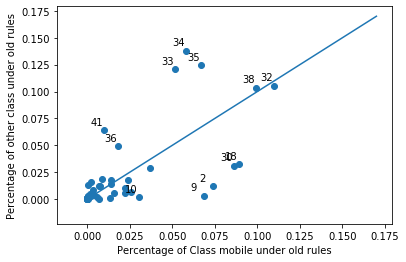

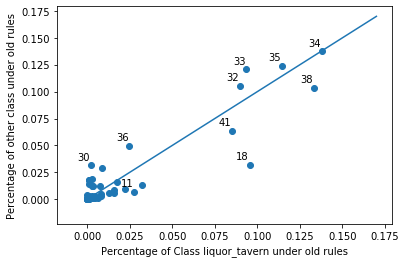

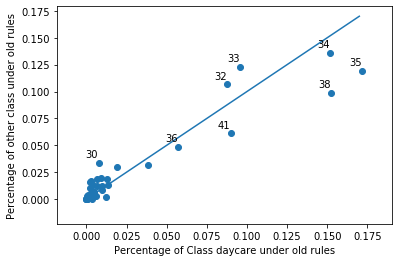

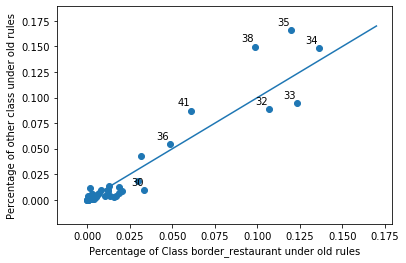

In [121]:
for i in range(4):
    x_index = [i]
    y_index = [0, 1, 2, 3]
    del y_index[i]    
    x_label = 'Percentage of Class '+ class_list[i] + ' under old rules'
    y_label = 'Percentage of other class under old rules'
    text_size = [0.05, 0.05, 0.008, -0.005, 0.17, 0.02, 0.02]
    add_line = True
    plot_scatter(stats_cluster_old, x_index, y_index, x_label, y_label, text_size, add_line)

We can see that under the old rules：

For Class mobile More common problem：
        2. facilities to maintain proper temperature
        9. water source: safe, hot & cold under city pressure
        18. no evidence of rodent or insect outer openings protected/rodent proofed, a written log shall be maintained available to the inspectors
        30. food in original container, properly labeled: customer advisory posted as needed
For Class mobile Less common problem：
        33. food and non-food contact equipment utensils clean, free of abrasive detergents
        34. floors: constructed per code, cleaned, good repair, coving installed, dust-less cleaning methods used
        35. walls, ceilings, attached equipment constructed per code: good repair, surfaces clean and dust-less cleaning methods
For Class liquor_tavern More common problem：
        18. no evidence of rodent or insect outer openings protected/rodent proofed, a written log shall be maintained available to the inspectors
        38. ventilation: rooms and equipment vented as required: plumbing: installed and maintained
For Class liquor_tavern Less common problem：
        33. food and non-food contact equipment utensils clean, free of abrasive detergents
For Class daycare More common problem：
        35. walls, ceilings, attached equipment constructed per code: good repair, surfaces clean and dust-less cleaning methods
        38. ventilation: rooms and equipment vented as required: plumbing: installed and maintained
        41. premises maintained free of litter, unnecessary articles, cleaning equipment properly stored
For Class daycare Less common problem：
        32. food and non-food contact surfaces properly designed, constructed and maintained
        33. food and non-food contact equipment utensils clean, free of abrasive detergents
For Class border_restaurant More common problem：
        32. food and non-food contact surfaces properly designed, constructed and maintained
        33. food and non-food contact equipment utensils clean, free of abrasive detergents
For Class border_restaurant Less common problem：
        35. walls, ceilings, attached equipment constructed per code: good repair, surfaces clean and dust-less cleaning methods
        38. ventilation: rooms and equipment vented as required: plumbing: installed and maintained
        41. premises maintained free of litter, unnecessary articles, cleaning equipment properly stored

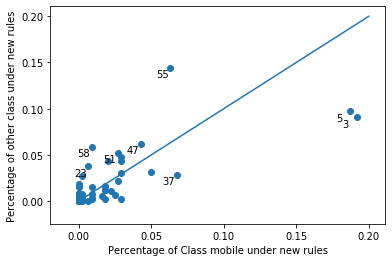

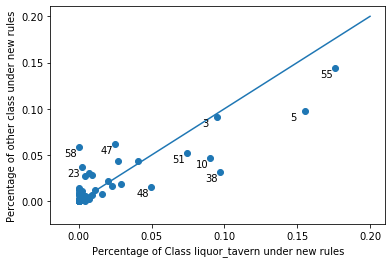

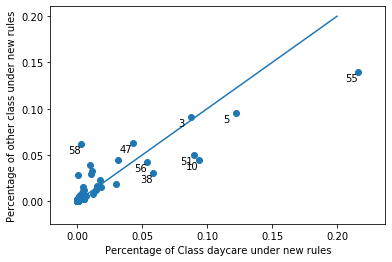

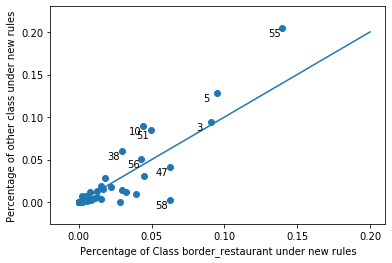

In [126]:
for i in range(4):
    x_index = [i]
    y_index = [0, 1, 2, 3]
    del y_index[i]    
    x_label = 'Percentage of Class '+ class_list[i] + ' under new rules'
    y_label ='Percentage of other class under new rules'
    text_size = [0.05, 0.05, 0.01, 0.01, 0.2, 0.03, 0.03]
    add_line = True
    plot_scatter(stats_cluster_new, x_index, y_index, x_label, y_label, text_size, add_line)

We can see that under the new rules：

For mobile More common problem：
        3. management, food employee and conditional employee; knowledge, responsibilities and reporting
        5. procedures for responding to vomiting and diarrheal events
For mobile Less common problem：
        55. physical facilities installed, maintained & clean
For liquor_tavern More common problem：
        5. procedures for responding to vomiting and diarrheal events
        10. adequate handwashing sinks properly supplied and accessible
        38. insects, rodents, & animals not present
For liquor_tavern Less common problem：
        47. food & non-food contact surfaces cleanable, properly designed, constructed & used
        58. allergen training as required
For daycare More common problem：
        55. physical facilities installed, maintained & clean
For daycare Less common problem：
        58. allergen training as required
For border_restaurant More common problem：
        58. allergen training as required
For border_restaurant Less common problem：
        55. physical facilities installed, maintained & clean

We can find the following phenomena：

1：The results of Class border_restaurant and Class daycare are almost the opposite. This is because these two categories take up most of the data, causing the total data to be subtracted from one of them is almost the other.

2：For mobile，temperature, water, employees and prevention problem are relatively common, while facilities problem are relatively rare.

3：For liquor_tavern，ventilation, pests problem are relatively common, while clean and allergies problem are relatively rare

4：For daycare, ventilation, garbage problem is relatively common, and cleaning and allergies problem are relatively rare

5：For border_restaurant, Clean, allergies problem are relatively common, ventilation and garbage problem is relatively rare

The above conclusions are basically in line with our perception.

## 计算每种violation的重犯率，研究其和出现概率的关系。并根据这两者寻找一些重点研究的violation number

Return rate of violation number: The number of times without corrections as a percentage of the total number of times. For each occurrence of the violation number, if he does not appear in the next check of the same 'License #', then it is a successful correction. Otherwise, it is a failure to correct. (the last time for each 'License #'.violation number is not a valid number because it cannot be judged whether it was successfully corrected)

In [63]:
def Return_rate(chicago_):
    # This function calculate the Return rate.
    # This function simplifies the calculation process by using the sparse matrix method.
    max_size = 100
    
    times = np.zeros(max_size)
    Not_corrected = np.zeros(max_size)
    sum_1 = np.zeros(max_size)
    sum_2 = np.zeros(max_size)

    # Pick out the data we need
    chicago_loced = chicago_.loc[:, "violation_number"]
    chicago_grouped = chicago_loced.groupby(chicago_['License #'])

    for name, group in chicago_grouped:
        mat = None
        
        # Does not consider the data of License # = 0 and License # = 999 (default data)
        if name == -999:
            continue
        if name == 0:
            continue
            
        # Statistics for each license #
        for i in list(group):
            #Convert each result list into a sparse matrix and merge them.
            col = np.array(list(i))
            size = col.size
            row = np.zeros(size)
            data = np.ones(size)
            a = csr_matrix((data, (row, col)), shape=(1, max_size)).toarray()
            if mat is None:
                mat = a
            else:
                mat = np.vstack((a, mat))
                
        # Statistics using sparse matrices
        if mat.shape[0] > 1:
            mat_1 = np.delete(mat, mat.shape[0]-1, axis = 0)
            mat_2 = np.delete(mat, 0, axis = 0)
            mat_3 = np.logical_and(mat_1, mat_2)
            sum_1 = np.sum(mat_1,axis=0)
            sum_2 = np.sum(mat_3,axis=0)
        
        #Accumulate all License # data
        times = times + sum_1
        Not_corrected = Not_corrected + sum_2
        sum_1 = np.zeros(max_size)
        sum_2 = np.zeros(max_size)
    return Not_corrected/times

In [ ]:
#Calculate the return rate before and after the revision of the regulations

before = chicago[chicago['Inspection Date'] < datetime(2018, 7, 1)].copy()
before_data = Return_rate(before)
before_data[46] = before_data[70]
before_data = before_data[1:47]
print("old")
plt.bar(range(len(before_data)), before_data)
plt.show()

after = chicago[chicago['Inspection Date'] >= datetime(2018, 7, 1)].copy()
after_data = Return_rate(after)
after_data = after_data[1:64]
print("new")
plt.bar(range(len(after_data)), after_data)
plt.show()

Make a scatter plot of the percentage of violation number and return rate, look for the relationship between this two and find some important violation number.


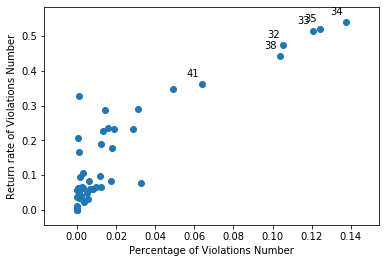

In [65]:
before_percentage = chicago_before.groupby('Violations Number').count()
index = list(map(int, before_percentage._stat_axis.values.tolist()))
before_percentage.index = index
before_percentage = before_percentage.sort_index()
before_percentage = before_percentage.iloc[:, 0]
sum_before_percentage = np.sum(before_percentage)
before_percentage = before_percentage/sum_before_percentage

text = before_percentage._stat_axis.values.tolist()
plt.scatter(before_percentage, before_data)
plt.xlabel('Percentage of Violations Number')
plt.ylabel('Return rate of Violations Number')
for j in range(len(before_data)):
    if(before_data[j] >= 0.3):
        if(before_percentage[j+1] >= 0.05):
            plt.annotate(text[j], xy = (before_percentage[j+1], before_data[j]), xytext = (before_percentage[j+1] - 0.008, before_data[j] + 0.02))
plt.show()



We can see that the ratios and return rates of the six regulations number before the revision ['32', '33', '34', '35', '38', '41'] are very high. We need to focus on the violation number later.

In [73]:
important_violation_number_old = ['32', '33', '34', '35', '38', '41']

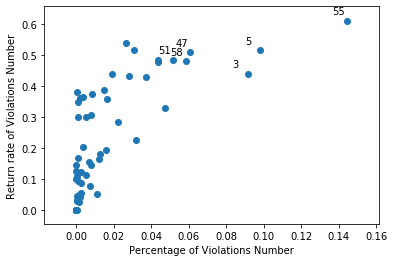

In [68]:
after_percentage = chicago_after.groupby('Violations Number').count()
index = list(map(int, after_percentage._stat_axis.values.tolist()))
after_percentage.index = index
after_percentage = after_percentage.sort_index()
after_percentage = after_percentage.iloc[:, 0]
sum_after_percentage = np.sum(after_percentage)
after_percentage = after_percentage/sum_after_percentage
text = after_percentage._stat_axis.values.tolist()
plt.scatter(after_percentage, after_data)
plt.xlabel('Percentage of Violations Number')
plt.ylabel('Return rate of Violations Number')
for j in range(len(after_data)):
    if(after_data[j] >= 0.3):
        if(after_percentage[j+1] >= 0.05):
            plt.annotate(text[j], xy = (after_percentage[j+1], after_data[j]), xytext = (after_percentage[j+1] - 0.008, after_data[j] + 0.02))
plt.show()

We can see that the ratios and return rates of the six violation number after the revision ['3', '5', '47', '51', '55', '58'] are very high. We need to focus on the violation number later.

In [69]:
important_violation_number_new = ['3', '5', '47', '51', '55', '58']

In addition, we can also see that the ratios and return rates of the violation number have a significant positive correlation. And the rate of return has obviously increased after the revision of the regulations. It may be that the review after the revision becomes more strict

## For some important violation number generate a word cloud according to comments

In [70]:
#Import the NLP library nltk and download some resources
import nltk
from nltk import ngrams
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zhuzhenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhuzhenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zhuzhenyu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [71]:
#Define function to count word frequency and draw word cloud

def word_frequency(data, x, y):
    print(x)
    data = data.values
    data = ''.join(data)
    
    # Analysis word frequency using n-gram method
    for n in range(5):
        grams = ngrams(data.split(), n)
        
    print(collections.Counter(grams).most_common(5))
    
def word_cloud(data, x, y):
    print(x)
    data = data.values
    data = ''.join(data)
    words = word_tokenize(data)
    
    # stopwords cleanup
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    filtered_words = [word for word in filtered_words if word not in stoplist]
    
    # Text data lemmatize
    filtered_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    filtered_words = [lemmatizer.lemmatize(word, pos='v') for word in filtered_words]
    
    # Analysis word frequency
    print(collections.Counter(filtered_words).most_common(20))
    
    # Drawing word cloud
    mask_image = np.array(Image.open("chicago.jpg"))
    mask_image[mask_image > 250] = 255

    word_cloud = WordCloud(colormap = "Dark2", background_color='white', mask = mask_image, 
                        width = 1165, height = 607,  max_words=1000, min_font_size = 1, relative_scaling = 0.2).generate(" ".join(filtered_words))
    plt.figure(figsize = (14,20))
    plt.imshow(word_cloud, interpolation="bilinear", cmap = plt.cm.autumn)
    plt.axis('off')
    plt.figure(figsize = (10,6))
    plt.show()
    word_cloud.to_file("word_cloud_" + x +".png" + y)

In [78]:
# Drawing word cloud / statistics word frequency for each important Violations Number

import matplotlib.pyplot as plt
from wordcloud.wordcloud import WordCloud
from PIL import Image
import collections 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

stoplist = ['.', ',', '(', ')', 'food']

wordcloud_old = chicago_exploded[chicago_exploded['Inspection Date'] < datetime(2018, 7, 1)].copy()
wordcloud_new = chicago_exploded[chicago_exploded['Inspection Date'] >= datetime(2018, 7, 1)].copy()

for x in important_violation_number_old:
    data = wordcloud_old.loc[wordcloud_old["Violations Number"] == x, "Comment"]
    word_frequency(data, x, "before")
#     word_cloud(data, x, "before")
    
for x in important_violation_number_new:
    data = wordcloud_new.loc[wordcloud_new["Violations Number"] == x, "Comment"]
    word_frequency(data, x, "after")
#     word_cloud(data, x, "after")

32
[(('food', 'and', 'non-food', 'contact'), 9705), (('smooth,', 'easily', 'cleanable,', 'and'), 9599), (('easily', 'cleanable,', 'and', 'durable,'), 9599), (('shall', 'be', 'in', 'good'), 9599), (('cleanable,', 'and', 'durable,', 'and'), 9598)]
33
[(('shall', 'be', 'thoroughly', 'cleaned'), 12804), (('be', 'thoroughly', 'cleaned', 'and'), 12804), (('utensils', 'shall', 'be', 'thoroughly'), 12802), (('thoroughly', 'cleaned', 'and', 'sanitized'), 12798), (('food', 'and', 'non-food', 'contact'), 10517)]
34
[(('be', 'smooth', 'and', 'easily'), 14204), (('be', 'kept', 'clean', 'and'), 13436), (('be', 'constructed', 'per', 'code,'), 13425), (('shall', 'be', 'constructed', 'per'), 13424), (('constructed', 'per', 'code,', 'be'), 13424)]
35
[(('in', 'good', 'repair', 'and'), 11837), (('be', 'in', 'good', 'repair'), 11836), (('shall', 'be', 'in', 'good'), 11834), (('ceilings', 'shall', 'be', 'in'), 11833), (('and', 'ceilings', 'shall', 'be'), 11832)]
38
[(('and', 'properly', 'connected', 'to'),

**Deleted columns: **

 'Census Tracts',
 'City',
 'Community Areas',
 'Historical Wards 2003-2015',
 'State',
 'Wards',
 'Zip Codes'
 'Location'

## Yelp data

In [ ]:
# # Read in scraped data from yelp
# file_list = ['1-1', '1-2', '3-1', '3-2', '3-3', '4']
# df_list = []

# for file in file_list:
#     yelp_default = read_clean('yelp_by_region/{0}.csv'.format(file)) 
#     df_list.append(yelp_default)

# yelp_default = read_clean('yelp_by_region/{0}.csv'.format('2'))
# yelp_default.drop(['Unnamed: 0'], axis = 1, inplace = True)
# df_list.append(yelp_default)


# combined = pd.concat(df_list, ignore_index=True).drop_duplicates().reset_index(drop=True)
# combined['business_name'] = combined['business_name'].replace({'&amp;' : '&'}, regex = True)
# combined['business_name'] = combined['business_name'].replace({'‘' : '\''}, regex = True)
# combined['business_name'] = combined['business_name'].replace({'’' : '\''}, regex = True)
# combined['categories'] = combined['categories'].replace({'&amp;' : '&'}, regex = True)
# # combined['business_name'] = combined['business_name'].str.replace(r'[^\x00-\x7F]+', '')
# combined['business_name'] = combined['business_name'].apply(lambda x: unidecode.unidecode(x))
# combined.to_csv('yelp.csv')
combined = pd.read_csv('yelp.csv')
yelp = combined.drop(columns=['Unnamed: 0', 'rank'])
yelp.head()

In [ ]:
yelp.shape

## Join Chicago and Yelp by address, name (contains)

In [ ]:
# join by address
# Join by he first four digits in an address only
chicago['A_code'] = chicago['Address'].apply(lambda x: x.split(" ")[0])
yelp['a_code'] = yelp['address'].apply(lambda x: x.split(" ")[0])
join_by_address = chicago.merge(yelp, left_on = 'A_code', right_on = 'a_code')
join_by_address.head()
print(join_by_address.shape)

In [ ]:
# filter by name: aka name contains business name, or business name contains aka name
sim_join_name = join_by_address[join_by_address.apply(lambda x: x['AKA Name'] in x['business_name'] or \
                                                 x['business_name'] in x['AKA Name'], axis = 1)]

def simlarity_join(row):
    A = row['Address'].split(' ')[1]
    a = row['address'].split(' ')[1]
    if len(A) == 1 and len(a) == 1:
        return a == A
    else:
        return True
    
sim_join = sim_join_name[sim_join_name.apply(lambda x: simlarity_join(x), axis = 1)]
sim_join.head()

In [ ]:
print('shape: ', sim_join.shape)
print("According license: ", sim_join['License #'].nunique())
print("According to resturant address: ", sim_join.address.nunique())
print("According to business name: ", sim_join["business_name"].nunique())

In [ ]:
# compare 3583 and 3276 means have the different resturants in the same address
# compare license 5137 and 3583(business_name, address] means have the same resturant but different license? why?
print(sim_join[['business_name', 'address']].drop_duplicates())

In [ ]:
sim_join[['AKA Name', 'Address', 'business_name', 'address']].drop_duplicates().head(500)
# spot some mistakes during merge 43860

In [ ]:
sim_join[sim_join['Facility Type'] == 'Restaurant']['License #'].nunique()

Jimmy John's : fast food chain. multiple sites but with the same address number. 
Subway

## Backup

In [ ]:
# Baseline method
joined = chicago.merge(combined, left_on = 'AKA Name', right_on = 'business_name')
len(joined.business_name)

In [ ]:
# join by the first four digits in an address and the business name
join_type_1 = joined.copy()
join_type_1['A_code_first'] = joined['Address'].apply(lambda x: x.split(" ")[0])
join_type_1['a_code_first'] = joined['address'].apply(lambda x: x.split(" ")[0])
join_type_1 = join_type_1[ (join_type_1['A_code_first'] == join_type_1['a_code_first'])].copy()
join_type_1.drop(['A_code_first', 'a_code_first'], axis=1, inplace=True)
join_type_1.head()
print("shape", join_type_1.shape)
print("According license: ", join_type_1['License #'].nunique())
print("According to resturant address: ", join_type_1.Address.nunique())
print("According to resturant name: ", join_type_1["DBA Name"].nunique())

**Finding: A single address can respond to **

A single address can correspond to a lot of buinesses. One single AKA name on one single address can have different license number. For example, establishment 'loop soup' at address '131 n clinton st'. 

In [ ]:
join_type_1.groupby('Address').count().sort_values(by = 'Inspection ID', ascending = False).head()

In [ ]:
join_type_1[ join_type_1['Address'] == '131 n clinton st' ]

In [ ]:
# join by the list of numbers appeared in an address and the business name
import re
join_type_2 = joined.copy()
join_type_2['A_code'] = joined['Address'].apply(lambda x: tuple(re.findall("\d+", x)) )
join_type_2['a_code'] = joined['address'].apply(lambda x: tuple(re.findall("\d+", x)) )
join_type_2 = join_type_2[(join_type_2['A_code'] == join_type_2['a_code'])]#.drop_duplicates() \
       #[['AKA Name', 'Address', 'business_name', 'address']]
join_type_2.drop(['A_code', 'a_code'], axis=1, inplace=True)
join_type_2.head()
print(join_type_2.shape)
# inspection ID, date, type, result, comment, 